## Imports

In [ ]:
import functools
import math

import sklearn
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.datasets import make_blobs
from IPython.display import clear_output
from matplotlib import rc
from matplotlib.colors import Normalize

In [ ]:
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = 10, 10
plt.rcParams['font.size'] = 12
sns.set_style('darkgrid')

In [ ]:
rc('animation', html='jshtml')

## Creating a dataset

In [ ]:
def make_dataset(n_samples, n_centers, norm, random_state=42):
    angle = np.arange(n_centers) / n_centers * 2 * np.pi + np.pi / 2
    centers = np.stack([np.cos(angle), np.sin(angle)], axis=1) * norm

    X, y = make_blobs(n_samples,
                      centers=np.array(centers),
                      random_state=random_state)
    return X / X.max(), y, centers / X.max()

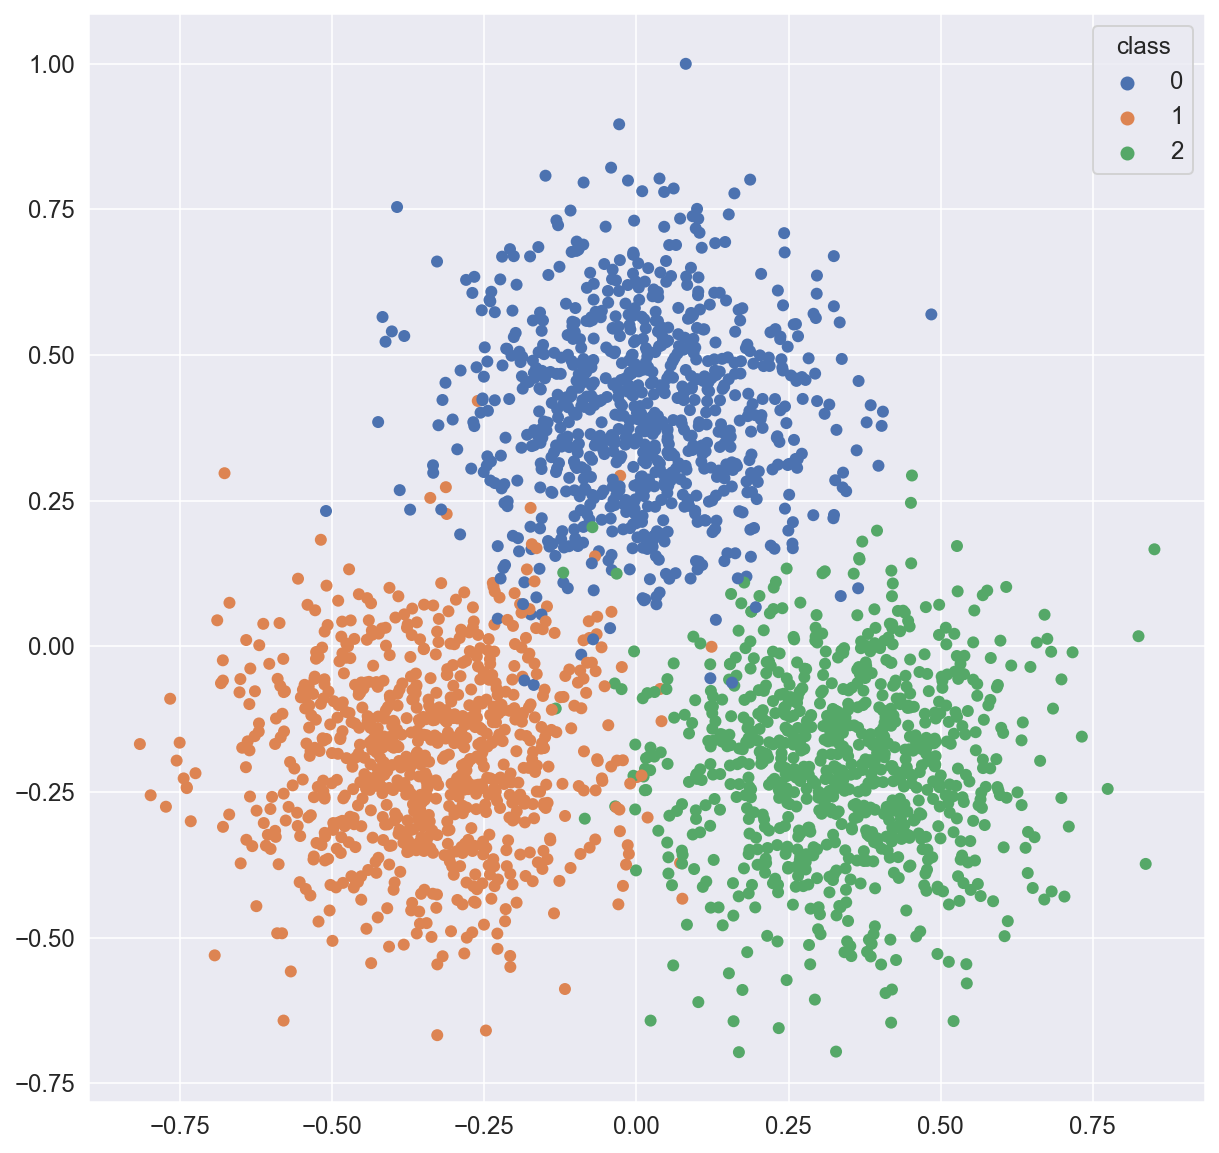

In [ ]:
n_clusters = 3
X, y, centers = make_dataset(2500, n_clusters, 2.5)
ax = sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, palette='deep', linewidth=0)
ax.legend(title='class')
plt.show()

In [ ]:
def infiniteloop(dataloader):
    while True:
        for sample in iter(dataloader):
            yield sample


batch_size = 32

centers = torch.FloatTensor(centers).unsqueeze(0)
dataset = torch.utils.data.TensorDataset(torch.FloatTensor(X),
                                         torch.LongTensor(y))
dataloader = torch.utils.data.DataLoader(dataset,
                                         shuffle=True,
                                         batch_size=32,
                                         drop_last=True)
dataloader = infiniteloop(dataloader)
assert next(iter(dataloader))[0].shape == (batch_size, 2), next(iter(dataloader))[1].shape == (batch_size, )

### Classifier

$X\in\mathbb R^{n \times d}$ - data sample, $Y\in\mathbb R^{n \times m}$ - OHE encoded class labels, $C\in\mathbb R^{m \times d}$ - cluster centers.

Distance to centers
$$d_{i,j} = \frac12 \|\mathbf x_i - \mathbf c_j\|_2^2$$

Class probabilities
$$\mathbf p_i = \text{softmax}(\mathbf d_i)$$

Cross entropy loss
$$\mathcal{L}(\mathbf x_i, \mathbf y_i) = -\sum_{j=1}^my_{i,j}\log(p_{i,j})$$

Calculating gradient
$$\frac{\partial\mathcal{L}}{\partial\mathbf d_i} = \mathbf p_i - \mathbf y_i$$
$$\frac{\partial d_{i,j}}{\partial\mathbf x_i} = \mathbf x_i - \mathbf c_j$$

Final expression for classifier guidance
$$\nabla_{\mathbf x_i}\log p(\mathbf y_i | \mathbf x_i) = \frac{\partial\mathcal{L}}{\partial\mathbf x_i} = \frac{\partial\mathbf d_i}{\partial\mathbf x_i} \cdot \frac{\partial\mathcal{L}}{\partial\mathbf d_i} = (\mathbf x_i - C)^T(\mathbf p_i - \mathbf y_i)$$

In [ ]:
def log_cls_prob_grad(x, label):
    x = x.unsqueeze(1)
    diff = x - centers
    dist = (diff ** 2).sum(dim=-1) / 2
    prob = F.softmax(dist, dim=-1)
    ohe = F.one_hot(label, n_clusters)
    grad = torch.matmul(torch.transpose(diff, -1, -2),
                        (prob - ohe).unsqueeze(-1))
    grad = grad.squeeze(-1)
    return grad

def auto_log_cls_prob_grad(x, label):
    grad_x = x.clone()
    grad_x.requires_grad = True
    
    x = grad_x.unsqueeze(1)
    dist = ((x - centers) ** 2).sum(dim=-1) / 2
    loss = F.cross_entropy(dist, label, reduction="sum")
    loss.backward()
    
    return grad_x.grad

example_x = torch.FloatTensor([[0.5, 0.5],
                               [-0.5, -0.2]])
example_label = torch.LongTensor([0, 2])

assert torch.allclose(log_cls_prob_grad(example_x, example_label),
                      auto_log_cls_prob_grad(example_x, example_label))

## Creating a model

In [ ]:
def extract(v, t, x_shape):
    """
    Extract some coefficients at specified timesteps, then reshape to
    [batch_size, 1, 1, 1, 1, ...] for broadcasting purposes.
    """
    out = torch.gather(v, index=t, dim=0).float()
    return out.view([t.shape[0]] + [1] * (len(x_shape) - 1))


class GaussianDiffusionTrainer(nn.Module):
    def __init__(self, model, beta_1, beta_T, T, conditional = False):
        super().__init__()

        self.model = model
        self.T = T
        self.conditional = conditional

        self.register_buffer(
            'betas', torch.linspace(beta_1, beta_T, T).double())
        alphas = 1. - self.betas
        alphas_bar = torch.cumprod(alphas, dim=0)

        # calculations for diffusion q(x_t | x_{t-1}) and others
        self.register_buffer(
            'sqrt_alphas_bar', torch.sqrt(alphas_bar))
        self.register_buffer(
            'sqrt_one_minus_alphas_bar', torch.sqrt(1. - alphas_bar))

    def forward(self, x_0, label = None):
        """
        Algorithm 1.
        """
        t = torch.randint(self.T, size=(x_0.shape[0], ), device=x_0.device)
        noise = torch.randn_like(x_0)
        x_t = (
            extract(self.sqrt_alphas_bar, t, x_0.shape) * x_0 +
            extract(self.sqrt_one_minus_alphas_bar, t, x_0.shape) * noise)
        if self.conditional:
            pred_eps = self.model(x_t, t, label)
        else:
            pred_eps = self.model(x_t, t)
        loss = F.mse_loss(pred_eps, noise, reduction='none')
        return loss


class GaussianDiffusionSampler(nn.Module):
    def __init__(self, model, beta_1, beta_T, T,
                 mean_type='epsilon', var_type='fixedlarge'):
        assert mean_type in ['xprev' 'xstart', 'epsilon_xstart', 'epsilon']
        assert var_type in ['fixedlarge', 'fixedsmall']
        super().__init__()

        self.model = model
        self.T = T
        self.mean_type = mean_type
        self.var_type = var_type

        self.register_buffer(
            'betas', torch.linspace(beta_1, beta_T, T).double())
        alphas = 1. - self.betas
        alphas_bar = torch.cumprod(alphas, dim=0)
        alphas_bar_prev = F.pad(alphas_bar, [1, 0], value=1)[:T]

        # calculations for diffusion q(x_t | x_{t-1}) and others
        self.register_buffer(
            'sqrt_recip_alphas_bar', torch.sqrt(1. / alphas_bar))
        self.register_buffer(
            'sqrt_recipm1_alphas_bar', torch.sqrt(1. / alphas_bar - 1))
        
        self.register_buffer(
            'recip_sqrt_alphas', torch.sqrt(1. / alphas))
        self.register_buffer(
            'eps_coef', self.recip_sqrt_alphas * self.betas / torch.sqrt(1. - alphas_bar))

        # calculations for posterior q(x_{t-1} | x_t, x_0)
        self.register_buffer(
            'posterior_var',
            self.betas * (1. - alphas_bar_prev) / (1. - alphas_bar))
        # below: log calculation clipped because the posterior variance is 0 at
        # the beginning of the diffusion chain
        self.register_buffer(
            'posterior_log_var_clipped',
            torch.log(
                torch.cat([self.posterior_var[1:2], self.posterior_var[1:]])))
        self.register_buffer(
            'posterior_mean_coef1',
            torch.sqrt(alphas_bar_prev) * self.betas / (1. - alphas_bar))
        self.register_buffer(
            'posterior_mean_coef2',
            torch.sqrt(alphas) * (1. - alphas_bar_prev) / (1. - alphas_bar))
        
        self.model_std = {
            # for fixedlarge, we set the initial (log-)variance like so to
            # get a better decoder log likelihood
            'fixedlarge': torch.sqrt(self.betas),
            'fixedsmall': torch.sqrt(self.betas * (1. - alphas_bar_prev) /
                                     (1. - alphas_bar)),
        }[self.var_type]

    def q_mean_variance(self, x_0, x_t, t):
        """
        Compute the mean and variance of the diffusion posterior
        q(x_{t-1} | x_t, x_0)
        """
        assert x_0.shape == x_t.shape
        posterior_mean = (
            extract(self.posterior_mean_coef1, t, x_t.shape) * x_0 +
            extract(self.posterior_mean_coef2, t, x_t.shape) * x_t
        )
        posterior_log_var_clipped = extract(
            self.posterior_log_var_clipped, t, x_t.shape)
        return posterior_mean, posterior_log_var_clipped

    def predict_xstart_from_eps(self, x_t, t, eps):
        assert x_t.shape == eps.shape
        return (
            extract(self.sqrt_recip_alphas_bar, t, x_t.shape) * x_t -
            extract(self.sqrt_recipm1_alphas_bar, t, x_t.shape) * eps
        )

    def predict_xstart_from_xprev(self, x_t, t, xprev):
        assert x_t.shape == xprev.shape
        return (  # (xprev - coef2*x_t) / coef1
            extract(
                1. / self.posterior_mean_coef1, t, x_t.shape) * xprev -
            extract(
                self.posterior_mean_coef2 / self.posterior_mean_coef1, t,
                x_t.shape) * x_t
        )

    def predict_xprev_from_eps(self, x_t, t, eps):
        assert x_t.shape == eps.shape
        return (
            extract(self.recip_sqrt_alphas, t, x_t.shape) * x_t -
            extract(self.eps_coef, t, x_t.shape) * eps
        )

    def p_mean_variance(self, x_t, t, label = None):
        model_std = extract(self.model_std, t, x_t.shape)

        # Mean parameterization
        if self.mean_type == 'xprev':       # the model predicts x_{t-1}
            x_prev = self.model(x_t, t)
            x_0 = self.predict_xstart_from_xprev(x_t, t, xprev=x_prev)
            model_mean = x_prev
        elif self.mean_type == 'xstart':    # the model predicts x_0
            x_0 = self.model(x_t, t)
            model_mean, _ = self.q_mean_variance(x_0, x_t, t)
        elif self.mean_type == 'epsilon_xstart':   # the model predicts epsilon, x_0 is computed
            eps = self.model(x_t, t)
            x_0 = self.predict_xstart_from_eps(x_t, t, eps=eps)
            model_mean, _ = self.q_mean_variance(x_0, x_t, t)
        elif self.mean_type == 'epsilon':   # the model predicts epsilon
            eps = self.model(x_t, t)
            model_mean = self.predict_xprev_from_eps(x_t, t, eps=eps)
        else:
            raise NotImplementedError(self.mean_type)

        return model_mean, model_std

    def forward(self, x_T, label = None):
        """
        Algorithm 2.
        """
        x_t = x_T
        for time_step in reversed(range(self.T)):
            t = x_t.new_ones([x_T.shape[0], ], dtype=torch.long) * time_step
            mean, std = self.p_mean_variance(x_t, t, label)
            # no noise when t == 0
            if time_step > 0:
                noise = torch.randn_like(x_t)
            else:
                noise = 0
            x_t = mean + std * noise
        x_0 = x_t
        return x_0
    
    @torch.no_grad()
    def generate_history(self, x_T, label = None):
        """
        Algorithm 2, returns full history.
        """
        x_list = []
        xstart_list = []

        x_t = x_T
        for time_step in reversed(range(self.T)):
            t = x_t.new_ones([x_T.shape[0], ], dtype=torch.long) * time_step
            mean, std = self.p_mean_variance(x_t, t, label)
            # no noise when t == 0
            if time_step > 0:
                noise = torch.randn_like(x_t)
            else:
                noise = 0
            x_t = mean + std * noise

            xstart = self.predict_xstart_from_eps(
                x_t, t, eps=self.model(x_t, t)).cpu().detach().numpy()
            xstart_list.append(xstart)

            x_list.append(x_t.cpu().detach().numpy())

        return x_list, xstart_list
    
    @torch.no_grad()
    def generate_directions(self, x, label = None):
        """
        Algorithm 2, returns full history.
        """
        x_directions = []

        for time_step in reversed(range(self.T)):
            t = x.new_ones([x.shape[0], ], dtype=torch.long) * time_step
            mean, std = self.p_mean_variance(x, t, label)

            x_directions.append(mean.cpu().detach().numpy())

        return x_directions

In [ ]:
def fourier_emb(x, n_fourier):
    return ([torch.cos(np.pi * 2 ** n * x) for n in range(1, n_fourier + 1)] +
            [torch.sin(np.pi * 2 ** n * x) for n in range(1, n_fourier + 1)])

class DiffusionMLP(nn.Module):
    def __init__(self, data_dim, hidden_dim, T, n_fourier=10):
        super().__init__()

        self.T = T
        self.n_fourier = n_fourier
        self.net = nn.Sequential(
            nn.Linear((data_dim + 1) * (n_fourier * 2 + 1), hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim * 4),
            nn.ReLU(),
            nn.Linear(hidden_dim * 4, 2),
        )

    def forward(self, x, t):
        t = t.unsqueeze(1) / self.T
        x = torch.cat([x] + [t] +
                      fourier_emb(x, self.n_fourier) +
                      fourier_emb(t, self.n_fourier), dim=1)
        return self.net(x)

### Guidance

In [ ]:
class ConditionalGaussianDiffusionTrainer(GaussianDiffusionTrainer):
    def __init__(self, *args, **kwargs):
        assert "conditional" not in kwargs
        super().__init__(*args, conditional=True, **kwargs)


class ClsGuidedGaussianDiffusionSampler(GaussianDiffusionSampler):
    def __init__(self, *args, weight, log_cls_prob_grad=log_cls_prob_grad, **kwargs):
        assert "mean_type" not in kwargs
        super().__init__(*args, mean_type="epsilon", **kwargs)
        self.log_cls_prob_grad = log_cls_prob_grad
        self.weight = weight
    
    def p_mean_variance(self, x_t, t, label):
        model_std = extract(self.model_std, t, x_t.shape)

        # Conditional mean parameterization
        eps = self.model(x_t, t, label) - self.weight * model_std * self.log_cls_prob_grad(x_t, label)
        model_mean = self.predict_xprev_from_eps(x_t, t, eps=eps)

        return model_mean, model_std


class ClsFreeGaussianDiffusionTrainer(GaussianDiffusionTrainer):
    def __init__(self, *args, p_uncond, **kwargs):
        assert "conditional" not in kwargs
        super().__init__(*args, conditional=True, **kwargs)
        self.p_uncond = p_uncond

    def forward(self, x_0, label = None):
        """
        Algorithm 1.
        """
        # Sample t and eps (noise)
        t = torch.randint(self.T, size=(x_0.shape[0], ), device=x_0.device)
        noise = torch.randn_like(x_0)
        
        # Randomly drop label for unconditional generation
        if np.random.rand() < self.p_uncond:
            label = None
        
        x_t = (
            extract(self.sqrt_alphas_bar, t, x_0.shape) * x_0 +
            extract(self.sqrt_one_minus_alphas_bar, t, x_0.shape) * noise)
        loss = F.mse_loss(self.model(x_t, t, label), noise, reduction='none')
        return loss

class ClsFreeGaussianDiffusionSampler(GaussianDiffusionSampler):
    def __init__(self, *args, weight, **kwargs):
        assert "mean_type" not in kwargs
        super().__init__(*args, mean_type="epsilon", **kwargs)
        self.weight = weight
    
    def p_mean_variance(self, x_t, t, label):
        model_std = extract(self.model_std, t, x_t.shape)

        # Conditional mean parameterization
        eps = (self.weight + 1) * self.model(x_t, t, label) - self.weight * self.model(x_t, t, label=None)
        model_mean = self.predict_xprev_from_eps(x_t, t, eps=eps)

        return model_mean, model_std

In [ ]:
class ConditionalDiffusionMLP(nn.Module):
    def __init__(self, data_dim, hidden_dim, T, n_classes, n_fourier=10):
        super().__init__()

        self.T = T
        self.n_fourier = n_fourier
        self.n_classes = n_classes
        self.net = nn.Sequential(
            nn.Linear((data_dim + 1) * (n_fourier * 2 + 1) + n_classes, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim * 4),
            nn.ReLU(),
            nn.Linear(hidden_dim * 4, 2),
        )

    def forward(self, x, t, label):
        if label is None:
            label = torch.zeros((x.shape[0], self.n_classes))
        else:
            label = F.one_hot(label, self.n_classes)
        
        t = t.unsqueeze(1) / self.T
        x = torch.cat([x] + [t] +
                      fourier_emb(x, self.n_fourier) +
                      fourier_emb(t, self.n_fourier) +
                      [label], dim=1)
        return self.net(x)

In [ ]:
def train_conditional(model, optim, trainer, sampler, name, n_steps = 50_001):
    losses = []
    x_T = torch.randn((128, 2))
    test_label = torch.randint(n_clusters, size=(x_T.shape[0], ))

    model.train()
    for step in range(n_steps):
        # save
        if step % 10000 == 0:
            ckpt = {
                'net_model': model.state_dict(),
                'optim': optim.state_dict(),
                'step': step,
                'x_T': x_T,
            }
            torch.save(ckpt, f'{name}_{step}.ckpt')

        # train
        optim.zero_grad()
        x_0, label = next(dataloader)
        x_0 = x_0.to(device)
        label = label.to(device)
        loss = trainer(x_0, label).mean()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.)
        optim.step()

        # log
        losses.append(loss.item())

        # sample
        if step % 1000 == 0:
            model.eval()
            with torch.no_grad():
                clear_output(True)
                x_0 = sampler(x_T.to(device), test_label.to(device))
                x_0 = x_0.cpu().detach()
                plt.figure(figsize=(20, 10))
                plt.title('Train loss and generated samples')
                plt.subplot(1, 2, 1)
                plt.xlabel('Train step')
                plt.ylabel('Loss')
                plt.plot(losses)
                plt.subplot(1, 2, 2)
                plt.xlim(-1.5, 1.5)
                plt.ylim(-1.5, 1.5)
                sns.scatterplot(x=X[:, 0], y=X[:, 1], color="red", alpha=0.1, linewidth=0,
                                label='True data')
                sns.scatterplot(x=x_0[:, 0], y=x_0[:, 1], hue=test_label, palette='deep', linewidth=0)
                plt.legend(loc='upper right')
                plt.show()
            model.train()

### Training

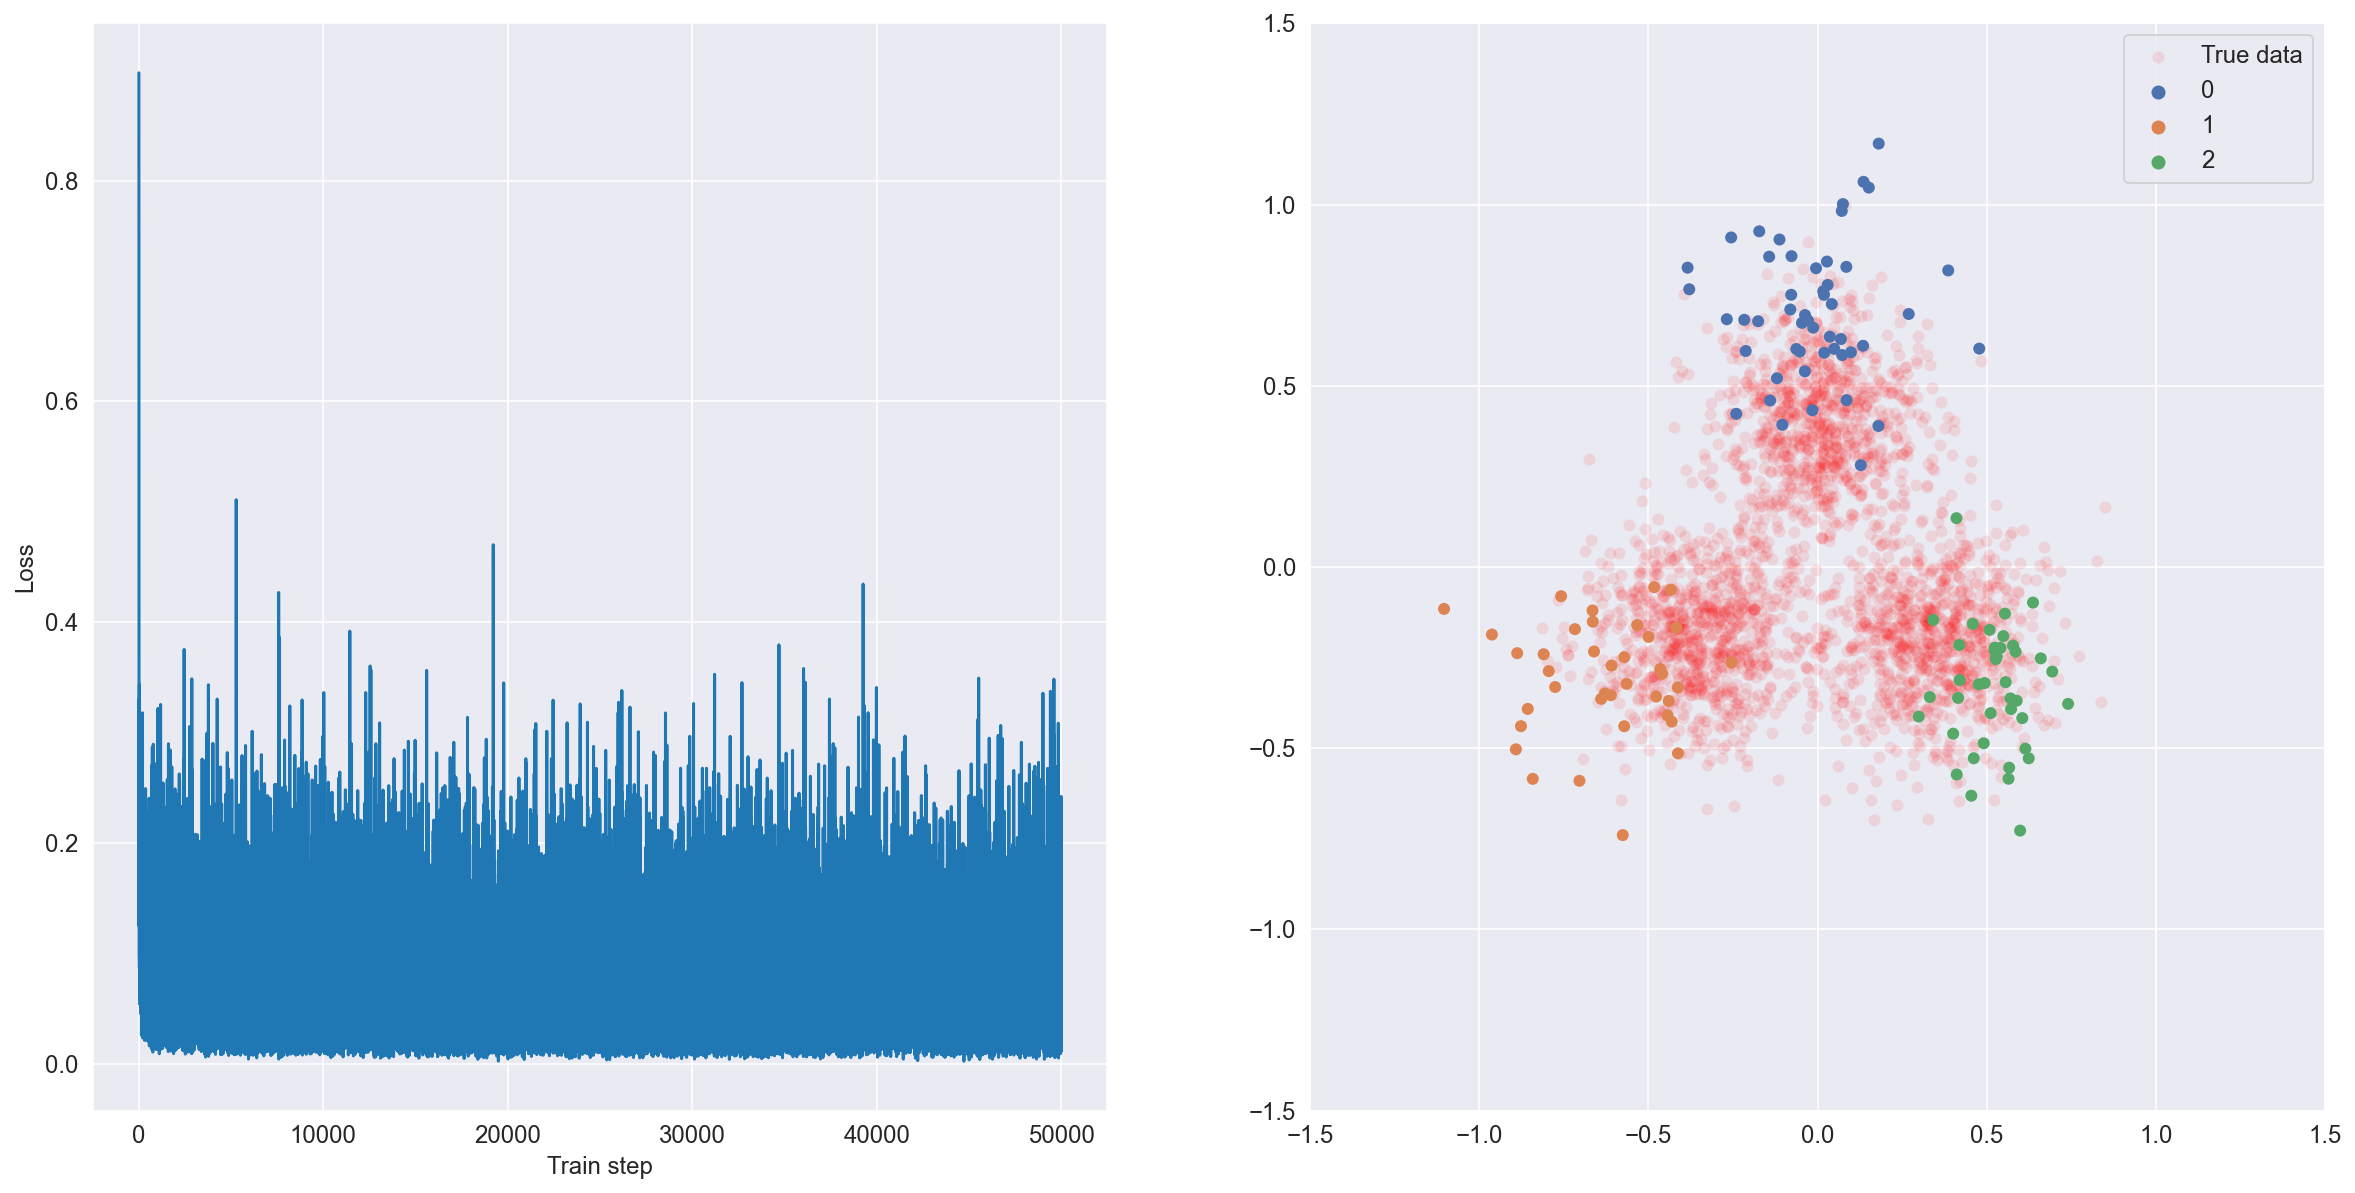

In [ ]:
beta_1 = 1e-4
beta_T = 0.02
T = 1000

device = 'cpu'

model = ConditionalDiffusionMLP(2, 128, 1000, n_clusters, n_clusters).to(device)
optim = torch.optim.Adam(model.parameters(), lr=2e-3)

trainer = ConditionalGaussianDiffusionTrainer(model, beta_1, beta_T, T).to(device)
sampler = ClsGuidedGaussianDiffusionSampler(model, beta_1, beta_T, T,
                                            log_cls_prob_grad=log_cls_prob_grad,
                                            weight=30).to(device)

train_conditional(model, optim, trainer, sampler, name="cls")

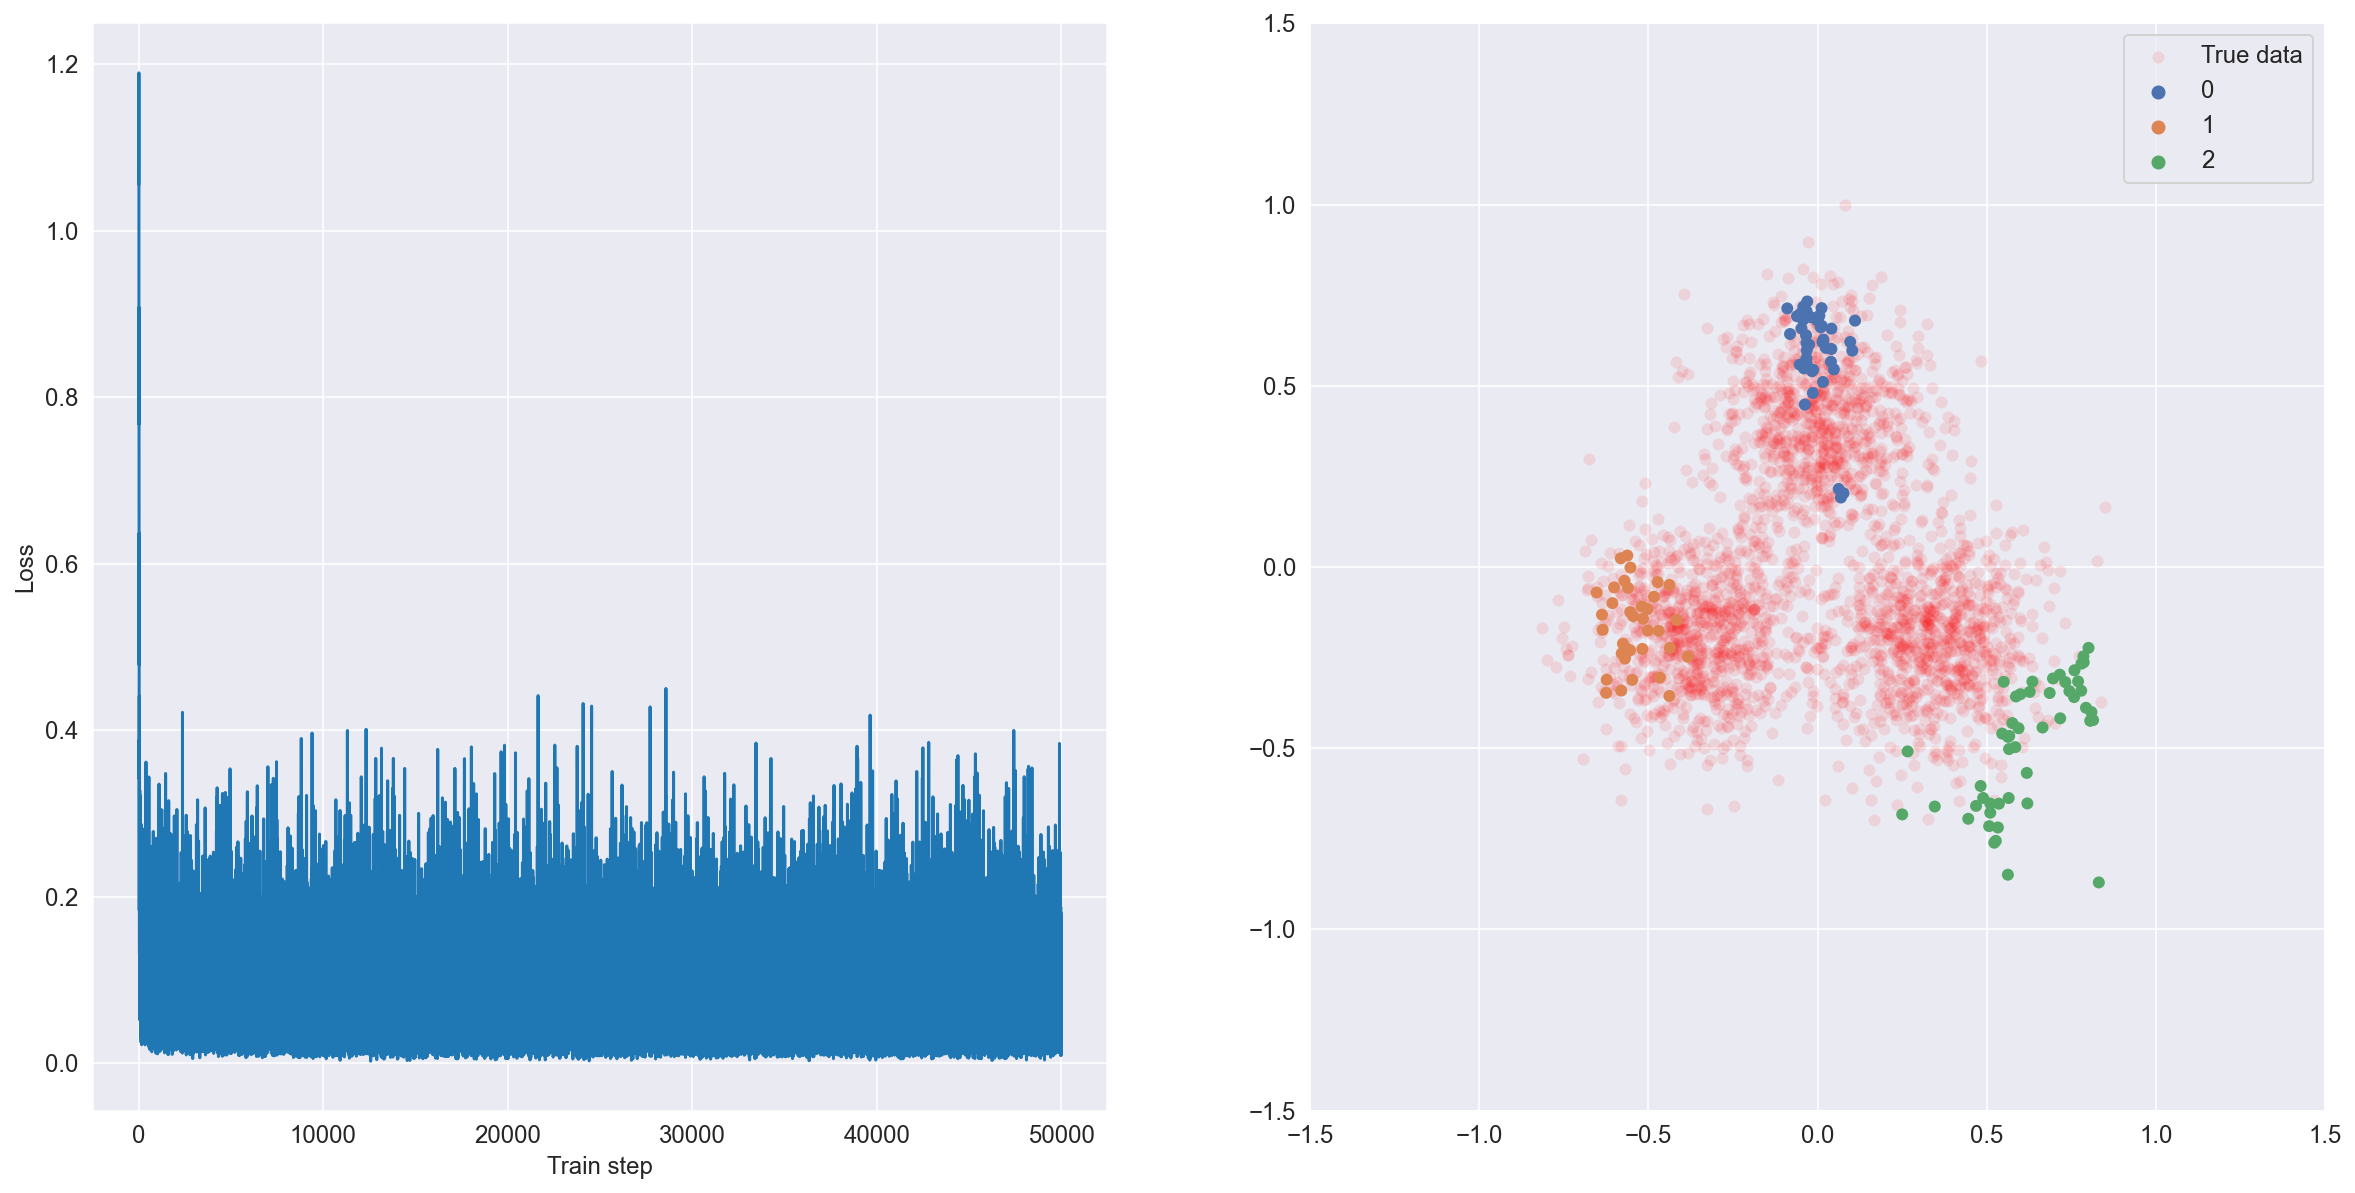

In [ ]:
beta_1 = 1e-4
beta_T = 0.02
T = 1000

device = 'cpu'

model = ConditionalDiffusionMLP(2, 128, 1000, n_clusters, n_clusters).to(device)
optim = torch.optim.Adam(model.parameters(), lr=2e-3)

trainer = ClsFreeGaussianDiffusionTrainer(model, beta_1, beta_T, T, p_uncond=0.2).to(device)
sampler = ClsFreeGaussianDiffusionSampler(model, beta_1, beta_T, T, weight=10).to(device)

train_conditional(model, optim, trainer, sampler, name="free")

## Visualising generation

### Generating $x_T$ samples with random class labels

In [ ]:
x_T = torch.randn((1000, 2))
test_label = torch.randint(n_clusters, size=(x_T.shape[0], ))

n_arrows = 10
d = torch.tensor([x / 10 for x in range(-15, 16)])
gx, gy = torch.meshgrid(d, d)
gx = gx.reshape(-1)
gy = gy.reshape(-1)
g = torch.stack([gx, gy], dim=1)
glen = len(g)

C:\Users\foma\anaconda3\envs\ml\lib\site-packages\torch\functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Sampling from trained models

In [ ]:
generated = {}
weights = {"cls": [0, 10, 30, 50],
           "free": [0, 3, 10, 16]}

for method, name in zip([ClsGuidedGaussianDiffusionSampler, ClsFreeGaussianDiffusionSampler],
                        ["cls", "free"]):
    generated[name] = {}
    for step in [50000]:
        generated[name][step] = {}

        model.load_state_dict(torch.load(f'{name}_{step}.ckpt')['net_model'])
        for weight in weights[name]:
            sampler = method(model, beta_1, beta_T, T, weight=weight).to(device)
            model.eval()

            generated[name][step][weight] = sampler(x_T.to(device), test_label.to(device)).cpu().detach()

### Animation functions

In [ ]:
def animate(weight, scatter, gen):
    scatter.set_offsets(gen[weight])

    return scatter,

In [ ]:
def generation_animation(generated, weights, steps, interval):
    fig, ax = plt.subplots(figsize=(8, 8))

    ax.scatter(X[:, 0], X[:, 1], color="red", alpha=0.1,
               label='True data')
    
    norm = Normalize(0, 10)
    scatter = ax.scatter(generated[steps][weights[0]][:, 0],
                         generated[steps][weights[0]][:, 1],
                         c=test_label, cmap="tab10", norm=norm)
    
    ax.set_xlim(-1.6, 1.6)
    ax.set_ylim(-1.6, 1.6)
    ax.legend(loc='upper right')

    ani = animation.FuncAnimation(
        fig,
        functools.partial(animate, gen=generated[steps]),
        weights, repeat=True, blit=True, fargs=(scatter,),
        interval=interval)

    return ani

### Results

### Sampling results by increasing guidance `weight`, starting from no guidance

Classifier guidance vs classifier free

In [ ]:
ani_50_cls = generation_animation(generated["cls"], weights["cls"], 50000, 1000)
ani_50_free = generation_animation(generated["free"], weights["free"], 50000, 1000)

In [ ]:
ani_50_cls

In [ ]:
ani_50_free

Wrong classes in guidance, but not in condition: $\tilde\epsilon_\theta=\epsilon_\theta(\mathbf x_t, c)-w\sigma_t\nabla_{\mathbf x_t}\log p(c' | \mathbf x_t)$

$c'(c)=$ blue $\rightarrow$ orange, orange $\rightarrow$ green, green $\rightarrow$ blue

In [ ]:
ani_50 = generation_animation(generated, weights, 50000, 1000)

In [ ]:
ani_50

Flip gradient sign: $\tilde\epsilon_\theta=\epsilon_\theta(\mathbf x_t, c)-w\sigma_t\nabla_{\mathbf x_t}\log p(c | \mathbf x_t)\ \rightarrow\ \tilde\epsilon_\theta=\epsilon_\theta(\mathbf x_t, c)+w\sigma_t\nabla_{\mathbf x_t}\log p(c | \mathbf x_t)$

In [ ]:
ani_50 = generation_animation(generated, weights, 50000, 1000)

In [ ]:
ani_50